In [67]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas kubernetes openai

In [68]:
import logging
logging.basicConfig(level=logging.DEBUG)
# 导入环境变量
import getpass
import os

# 定义函数，设置未定义的环境变量
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# 设置 OPENAI API 密钥
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

import time
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

# 初始化两个工具
tavily_tool = TavilySearchResults(max_results=5)
# 执行 Python 代码的工具，谨慎使用
python_repl_tool = PythonREPLTool()

In [69]:
# 定义消息 Agent 的节点
from langchain_core.messages import HumanMessage

# 定义一个消息代理节点，把结果封装成 HumanMessage 类型
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [ ]:
# 定义 supervisor Agent 和调度逻辑
# 管理员 Agent，负责决定下一个由哪个 Agent 来执行任务

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal,Sequence
import operator
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

# 定义成员 Agent 和系统提示语，告诉 supervisor 要负责调度多个 Agent
members = ["Researcher","Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] + members

# 定义 supervisor 的响应类，选择下一个执行的 Agent
class routeResponse(BaseModel):
    next: Literal[*options]

# 创建提示语模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            "Or should we FINISH Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

# 定义 LLM 模型和 supervisor_agent 函数
llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/JSV7aW5pdDogeydmbG93Y2hhcnQnOiB7J2N1cnZlJzogJ2xpbmVhcid9fX0lJQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCVJlc2VhcmNoZXIoUmVzZWFyY2hlcikKCUNvZGVyKENvZGVyKQoJc3VwZXJ2aXNvcihzdXBlcnZpc29yKQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCUNvZGVyIC0tPiBzdXBlcnZpc29yOwoJUmVzZWFyY2hlciAtLT4gc3VwZXJ2aXNvcjsKCV9fc3RhcnRfXyAtLT4gc3VwZXJ2aXNvcjsKCXN1cGVydmlzb3IgLS4tPiBSZXNlYXJjaGVyOwoJc3VwZXJ2aXNvciAtLi0+IENvZGVyOwoJc3VwZXJ2aXNvciAtLiAmbmJzcDtGSU5JU0gmbmJzcDsgLi0+IF9fZW5kX187CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 15436


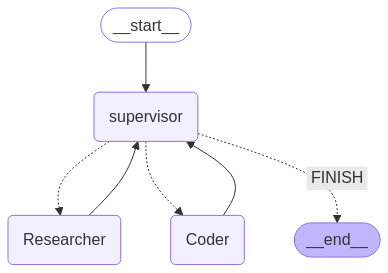

In [71]:
# 定义工作流和 Graph（有向有环图）
# 创建工作流，并且给节点添加 route 路由逻辑

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
import functools

# 创建 research agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# code agent
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# 创建 Graph 并且添加节点
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

# 定义路由逻辑
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k:k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.add_edge(START, "supervisor")

# 编译 Graph
graph = workflow.compile()

# 展示 Graph
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass






In [73]:
# 硬编码 Event 测试效果
from langchain_core.messages import HumanMessage

# name_list = ["Ashish Vaswani", "Noam Shazeer", "Niki Parmar", "Jakob Uszkoreit", "Llion Jones", "Aidan N. Gomez",
#              "Łukasz Kaiser", "Illia Polosukhin"]
for s in graph.stream(
    {
        "messages": [
            #HumanMessage(content="deployment: nginx, namespace: default, event: Back-off pulling image 'nginx:latess'")
            HumanMessage(content="将下列人名优先用姓氏、再使用名字进行排序，排序方法，需要先获取最快的方法，并将结果打印出来: \n'Ashish Vaswani', 'Noam Shazeer', 'Niki Parmar', 'Jakob Uszkoreit', 'Llion Jones',"
            "'Aidan N. Gomez','Łukasz Kaiser', 'Illia Polosukhin'")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'headers': {'X-Stainless-Helper-Method': 'beta.chat.completions.parse'}, 'files': None, 'post_parser': <function Completions.parse.<locals>.parser at 0x00000146FD13B6A0>, 'json_data': {'messages': [{'content': 'You are a supervisor tasked with managing a conversation between the following workers: Researcher, Coder. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.', 'role': 'system'}, {'content': "将下列人名优先用姓氏、再使用名字进行排序，排序方法，需要先获取最快的方法，并将结果打印出来: \n'Ashish Vaswani', 'Noam Shazeer', 'Niki Parmar', 'Jakob Uszkoreit', 'Llion Jones','Aidan N. Gomez','Łukasz Kaiser', 'Illia Polosukhin'", 'role': 'user'}, {'content': "use Resarcher agent to find the best python code first, and then use the Coder agent to exe the code with user inputOr should we FINISH Select one of: ['FINISH'

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:38:23 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d41b182f52e9e4-LAX'), (b'Openai-Organization', b'user-gaur1qofdkweai0q2xgkpwmz'), (b'Openai-Processing-Ms', b'1428'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=B_pyCwxnpikqSrHeCphkeqcylFL2qU0cdoW2aloPO8A-1741455503-1.0.1.1-W7nGvcihkyxlJh0KlvCtgjDC1qvoIZjlRKD6uxBTrxAoBT6HzuAlF0hiZYz6RaKPUJISWiHY93p1Gb4EOJUaDt2HyC2wLJlLUqXlgBVCBO0; path=/; expires=Sat, 08-Mar-25 18:08:23 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-O

{'Researcher': {'messages': [HumanMessage(content='最快的方法来对名字按姓氏或名字排序，您可以直接输入列表到以下在线工具或方法中：\n\n1. **按姓氏排序**：\n    - 在线工具：[Alphabetizer](https://alphabetizer.flap.tv/alphabetize-by-last-name.php)，可直接根据姓氏对列表进行排序，只需粘贴名字点击排序按钮。\n    - Microsoft Word/Excel 等方法：在段落组中使用“排序”命令，并在选项中选择按姓氏排序。[参考链接](https://answers.microsoft.com/en-us/msoffice/forum/all/how-do-i-alphabetize-by-last-name-when-the-list-is/256ec325-7176-e011-8dfc-68b599b31bf5)\n   \n2. **按名字排序**：\n    - 使用通用的在线排序工具，例如：[Wordcounter - Alphabetize](https://wordcounter.net/alphabetize)，粘贴名字以按字母顺序排列。\n\n这些工具和方法能快速对名字进行对应方式的排序。', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:38:32 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'394'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'd0e2f6b0-ea57-4b8f-a611-ba65763e51b9'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'347'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-eastus-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'352'), (b'X-Ms-Client-Request-Id', b'd0e2f6b0-ea57-4b8f-a611-ba65763e51b9'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'150'), (b'X-Ratelimit-Limit-Tokens', b'150000'), (b'X-Ratelimit-Remaining-Requests', b'149'), (b'X-Ratelimit-Remaining-Tokens', b'149063'), (b'X-Request-Id', b'e9a4b305-698d-4f55-8e39-9722d2a04380'), (b'X-Shel

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:38:34 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Apim-Request-Id', b'e64e85b6-0ecc-4a47-a35a-349314e64879'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Cmp-Upstream-Response-Duration', b'1048'), (b'Ms-Azureml-Model-Time', b'1077'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-eastus2-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'1079'), (b'X-Ms-Client-Request-Id', b'e64e85b6-0ecc-4a47-a35a-349314e64879'), (b'X-Ms-Rai-Invoked', b'true'), (b'X-Ms-Region', b'East US 2'), (b'X-Ratelimit-Limit-Requests', b'300'), (b'X-Ratelimit-Limit-Tokens', b'300000'), (b'X-Ratelimit-Remaining-Requests', b'299'), (b'X-Ratelimit-Remaining-To

{'Researcher': {'messages': [HumanMessage(content='以下是最快的在线排序工具和方法，可以根据姓氏或名字对名字列表进行排序：\n\n### 按姓氏排序\n- 使用工具：[Alphabetizer](https://alphabetizer.flap.tv/alphabetize-by-last-name.php)：提供了一个直接基于姓氏排序的选项，可将名字重组，使姓氏出现在首位，然后排序。\n- 方法：您可以通过 Microsoft Word/Excel 来实现姓氏排序。参考 [此链接](https://answers.microsoft.com/en-us/msoffice/forum/all/how-do-i-alphabetize-by-last-name-when-the-list-is/256ec325-7176-e011-8dfc-68b599b31bf5)：选择列表，点击“段落”功能组中的“排序”，在选项中选择按照“姓氏”排序。\n\n### 按名字排序\n- 使用工具：[Wordcounter](https://wordcounter.net/alphabetize)：此工具允许按名字排列顺序，只需复制原始列表粘贴到文本框中即可看到结果。\n\n根据需求，只需访问这些工具/文章链接，就可以轻松完成排序操作。准备好后，提供具体值，可立即执行排序！', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:38:41 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'988'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'8be2667a-06c7-49d3-b436-96028c0ab194'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Cmp-Upstream-Response-Duration', b'196'), (b'Ms-Azureml-Model-Time', b'237'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-eastus2-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'240'), (b'X-Ms-Client-Request-Id', b'8be2667a-06c7-49d3-b436-96028c0ab194'), (b'X-Ms-Rai-Invoked', b'true'), (b'X-Ms-Region', b'East US 2'), (b'X-Ratelimit-Limit-Requests', b'300'), (b'X-Ratelimit-Limit-Tokens', b'300000'), (b'X-Ratelimit-Remaining-Requests', b'299'), (b'X-Ratelimit-Remaining-Tokens', b'298118'), (b'X-Request-Id', b'f2

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:38:43 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'917'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'3a21719a-97ad-4b61-8f6a-b66538920254'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'1183'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'1185'), (b'X-Ms-Client-Request-Id', b'3a21719a-97ad-4b61-8f6a-b66538920254'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'448'), (b'X-Ratelimit-Remaining-Tokens', b'445865'), (b'X-Request-Id', b'099aab7d-a4a0-4f19-8907-fbeae7e950d8'), (b'X

{'Researcher': {'messages': [HumanMessage(content='为了快速按姓氏或名字对一列名字进行排序，您可以使用以下方法：\n\n### 最快的在线工具和方法：\n1. **在线工具：**\n   - 您可以使用 [Alphabetizer](https://alphabetizer.flap.tv/alphabetize-by-last-name.php) 工具，它有特定的功能可以按姓氏排序。复制您的名字列表，将其粘贴到文本框中，并选择“按姓氏排序”。\n   \n2. **Excel/Word 排序方法：**\n   - 在 Excel 或 Word 中，可以通过选择数据后，在数据菜单中使用排序功能，以“子段”或者“段落”方式排序。具体步骤可以参考 [Microsoft 官方指导](https://support.microsoft.com/zh-cn/office/%E5%AF%B9%E5%8C%BA%E5%9F%9F%E6%88%96%E8%A1%A8%E4%B8%AD%E7%9A%84%E6%95%B0%E6%8D%AE%E8%BF%9B%E8%A1%8C%E6%8E%92%E5%BA%8F-62d0b95d-2a90-4610-a6ae-2e545c4a4654)。\n\n### 按姓氏排序方法：\n- 姓氏是名字中的最后一个单词，您可以手动或使用编程语言如 Python，通过分割字符串的方式提取姓氏，然后按字母顺序排序。\n\n### 按名字排序方法：\n- 首名字是名字中的第一个单词，类似地，可以通过分割字符串的方式提取并排序。\n\n这几种工具以及方法提供了不同的选择，您可以选择最适合的方式来实现快速排序。', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:38:57 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'396'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'a70b5c8c-e014-4686-9365-a257ac0d66c6'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'252'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-eastus-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'254'), (b'X-Ms-Client-Request-Id', b'a70b5c8c-e014-4686-9365-a257ac0d66c6'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'150'), (b'X-Ratelimit-Limit-Tokens', b'150000'), (b'X-Ratelimit-Remaining-Requests', b'149'), (b'X-Ratelimit-Remaining-Tokens', b'147817'), (b'X-Request-Id', b'eb3305a3-0e45-4619-ad66-d517f625fa9c'), (b'X-Shel

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:38:59 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d41bf8bec1e9e4-LAX'), (b'Openai-Organization', b'user-gaur1qofdkweai0q2xgkpwmz'), (b'Openai-Processing-Ms', b'1598'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=pjEZbh_yxI1ZASgDR9KIme06QXR.YCHZlpwW_vnibQ0-1741455539-1.0.1.1-j8shwQOG68Rz0tEbuebd_KcOG2j8I3y_T7blM.hz4l.Wpmvf3OPBI_vj8ov8lvbcbm3xtloeTCKKcbf4e7UPqlXHMj3C4wVIOyqHkkZxvaU; path=/; expires=Sat, 08-Mar-25 18:08:59 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-O

{'Researcher': {'messages': [HumanMessage(content='根据搜索到的信息，这里有几种快速的方法可以按姓氏和名字对名单进行排序：\n\n### 按姓氏排序的方法：\n1. **Excel/Word 排序：**\n   - 选择名字列表所在的列，在“数据”选项卡中点击“文本到列”，将名字和姓氏分离。\n   - 使用段落组中的“排序”功能，按“姓氏”排序。参考 [微软支持网站](https://answers.microsoft.com/en-us/msoffice/forum/all/how-do-i-alphabetize-by-last-name-when-the-list-is/256ec325-7176-e011-8dfc-68b599b31bf5)。\n   \n2. **在线工具：**\n   - 使用 [Alphabetizer](https://alphabetizer.flap.tv/alphabetize-by-last-name.php) 在线工具，可以将名字根据姓氏直接排序。\n\n### 按名字排序的方法：\n1. **Excel 排序：**\n   - 在 Excel 中，您可以对名字的列直接进行排序，不需要额外的处理。可以参考这 [Excel 排序指南](https://www.xelplus.com/alphabetize-in-excel/)。\n\n2. **快速排序算法：**\n   - 使用快速排序（Quicksort）算法，这是一种效率较高的 O(nlogn)复杂度排序算法，适合在编程中对大量名字进行排序。参考 [StackOverflow](https://stackoverflow.com/questions/27767055/sorting-names-by-alphabetical-order-more-efficient-way)。\n\n根据需求，您可以选择使用上述工具或方法进行快速排序。', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:39:09 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'803'), (b'Connection', b'keep-alive'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d41c3e8bbae9e4-LAX'), (b'Openai-Organization', b'user-clh0qptkz883tzca034f7y4f'), (b'Openai-Processing-Ms', b'357'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=cyXrib7ESz6AV2RROfKzOJAnVSWVNhc.F4YTCtZ4rp8-1741455549-1.0.1.1-sRgYVzNiPWSuaO72SIQoeKlNoML16JgEIA94YtyItuLXJ2QneEsJF1p6xCcbI5FNX_V_qawZgBwmEnG6wIMy.dncRI6QBhFf_HF9ZNBjLGI; path=/; expires=Sat, 08-Mar-25 18:09:09 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Oneapi-Reque

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:39:11 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'587'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'38945374-7712-44e3-a39a-3975dcc335a9'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'436'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-02'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'454'), (b'X-Ms-Client-Request-Id', b'38945374-7712-44e3-a39a-3975dcc335a9'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'449'), (b'X-Ratelimit-Remaining-Tokens', b'444541'), (b'X-Request-Id', b'b4057761-3202-4ae4-95f9-d6205bf1bee1'), (b'X-S

{'Researcher': {'messages': [HumanMessage(content='为了快速按姓氏或名字对一列名字进行排序，您可以使用以下在线工具：\n\n### 在线工具推荐：\n1. **[Alphabetizer](https://alphabetizer.flap.tv/)**:\n   - 这个工具提供根据姓氏排序的功能。您只需将名字列表粘贴到工具中，并选择“按姓氏排序”。\n\n2. **[Wordcounter Alphabetize](https://wordcounter.net/alphabetize)**:\n   - 一个简单易用的工具，可以轻松地按字母顺序排列您的列表，只需将名字列表粘贴进去即可。\n\n3. **[Convert Case A-Z Sort Tool](https://www.convertcase.com/text/sort-from-a-z)**:\n   - 提供按字母顺序排列列表的功能，适用于任何列表。\n\n您可以选择其中任何一个在线工具来快速实现您的排序需求。', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:39:20 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'803'), (b'Connection', b'keep-alive'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d41c7b9d16e9e4-LAX'), (b'Openai-Organization', b'user-g2wqe6dhx3vba59el5watu4x'), (b'Openai-Processing-Ms', b'839'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=3PhLuE9P8R7i_yEnTvFoXtoLvKBVBPGLdFJ6Lzp_IIA-1741455559-1.0.1.1-Sa3Q0cmBiq6PIGxOAkNTwDrWGRMpEKkfcnjNCUwbe0pCCaYs2JAoGL91pTh0Xa9faL._7.79IVMPRWN4cpiTJLqpiMOWwHiWb89akzkm63Y; path=/; expires=Sat, 08-Mar-25 18:09:19 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Oneapi-Reque

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:39:24 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'803'), (b'Connection', b'keep-alive'), (b'Apim-Request-Id', b'bd2fa10c-4e6e-4681-a750-997d4b64d84f'), (b'Azureml-Model-Session', b'v20250225-1-161802030'), (b'Ms-Azureml-Model-Time', b'3913'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Aml-Cluster', b'hyena-japaneast-01'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Envoy-Upstream-Service-Time', b'3916'), (b'X-Ms-Client-Request-Id', b'bd2fa10c-4e6e-4681-a750-997d4b64d84f'), (b'X-Ms-Rai-Invoked', b'false'), (b'X-Ms-Region', b'East US'), (b'X-Ratelimit-Limit-Requests', b'450'), (b'X-Ratelimit-Limit-Tokens', b'450000'), (b'X-Ratelimit-Remaining-Requests', b'449'), (b'X-Ratelimit-Remaining-Tokens', b'443114'), (b'X-Request-Id', b'9004e499-efab-4eef-ac1f-c93d925588fe'), (b'X

{'Researcher': {'messages': [HumanMessage(content='以下是可以帮助您快速排序名字列表的工具和方法：\n\n### 按姓氏进行排序：\n1. **[Alphabetizer](https://alphabetizer.flap.tv/alphabetize-by-last-name.php)**: 这个在线工具提供按姓氏排序的功能，只需将名字列表粘贴并选择对应选项即可。\n2. **[Microsoft Word/Excel 排序](https://answers.microsoft.com/en-us/msoffice/forum/all/how-do-i-alphabetize-by-last-name-when-the-list-is/256ec325-7176-e011-8dfc-68b599b31bf5)**: 选择列表，点击段落功能组中的“排序”，在选项中选择按“姓氏”排序。\n\n### 按名字进行排序：\n1. **[Alphabetizer](https://alphabetizer.flap.tv/)**: 提供一般的字母顺序排序功能，可以对名字进行排序。\n2. **[Wordcounter](https://wordcounter.net/alphabetize)**: 只需粘贴名字，它可以自动按字母顺序排列列表。\n3. **[Convert Case A-Z Sort Tool](https://www.convertcase.com/text/sort-from-a-z)**: 允许按字母顺序对名字列表进行排序。\n\n这些工具可以简单快速地按照您的需求对名字进行排序。您可以根据需要选择合适的工具进行操作。', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:39:33 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'806'), (b'Connection', b'keep-alive'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d41cd32d9de9e4-LAX'), (b'Openai-Organization', b'user-iiidubszcurjmhzvshpuaycc'), (b'Openai-Processing-Ms', b'349'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=vZ84_kB2H10NJXH9ry9FJYyp9UvWHKHal0.RSR070cw-1741455573-1.0.1.1-pahS9pNYBaSu7QUgjkASIOcGyU6vMAPgpDHcxFyFyW92hJ3lZIVPQ.P4sKiyEAlwr_dQx..2B56YIsO2yXABOggHtx7mVs5NaVdPzQun3mM; path=/; expires=Sat, 08-Mar-25 18:09:33 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Oneapi-Reque

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:39:35 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d41cd8c841e9e4-LAX'), (b'Openai-Organization', b'user-q9m7kv0t3b8xhl9nrdveendu'), (b'Openai-Processing-Ms', b'1734'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=OCYN0IcLmdDPq4iQGIeA4qwjU4W7vx_mKRju3soXwYQ-1741455575-1.0.1.1-p8j1BKeSpyCnuaHbHT0y4lKPOfIqobJ1LuTsVuX6imLGyzc_kb3ZnqUzpGdB8QLEXfu2UeuYnsmYrLEldykkqAqoYQtxydijaBbEUoazOlE; path=/; expires=Sat, 08-Mar-25 18:09:35 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-O

{'Researcher': {'messages': [HumanMessage(content='### 快速按姓氏排序的方法\n\n1. **Excel 使用方法**: \n   - 可以在 Excel 中使用“文本到列”功能，将名字和姓氏分开到不同的列中，然后使用排序功能按姓氏排序。[查看详细指南](https://oit.caes.uga.edu/sort-text-based-list-by-last-name-using-excel/)。\n   - 您还可以参考视频教程，展示了五种在 Excel 中按姓氏排序的方法，例如使用公式、文本到列等。[观看教程](https://www.youtube.com/watch?v=jL8vDnChmDw)。\n\n2. **在线工具**: \n   - [Alphabetizer](https://alphabetizer.flap.tv/alphabetize-by-last-name.php) 是一个专门设计用于根据姓氏将名字列表进行排序的工具。\n\n### 快速按名字排序的方法\n\n1. **排序算法**:\n   - 使用 Quicksort（快速排序）算法，其时间复杂度为 O(nlogn)，是一种常见的高效排序算法。[更多信息](https://stackoverflow.com/questions/27767055/sorting-names-by-alphabetical-order-more-efficient-way)。\n\n2. **在线工具**:\n   - [WordCounter Alphabetize Tool](https://wordcounter.net/alphabetize) 允许快速按名字字母顺序对列表排序，只需将名字粘贴进去即可。\n\n这些方法和工具能帮助您快速而有效地根据需要对名字进行排序。', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:39:43 GMT'), (b'Content-Type', b'application/json'), (b'Content-Length', b'803'), (b'Connection', b'keep-alive'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d41d0f2924e9e4-LAX'), (b'Openai-Organization', b'user-5qifmju5gfmzn2unutgysczo'), (b'Openai-Processing-Ms', b'515'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=9spied4RotzxME9dcM4hi0dNElr1RzuzMUO6AgiqQ3o-1741455583-1.0.1.1-BCNy7DSLZyYX.QfK5uWBQ3cUmu5twZxv78wjEkBo7Ywk3gxPstvyBQF9jntcey4vm.WpZ7kfbkajVgBJvvRNwdlsS1Ec_y.6ItdrtL7H8LA; path=/; expires=Sat, 08-Mar-25 18:09:43 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-Options', b'nosniff'), (b'X-Oneapi-Reque

{'supervisor': {'next': 'Researcher'}}
----


DEBUG:httpcore.http11:receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Server', b'nginx'), (b'Date', b'Sat, 08 Mar 2025 17:39:45 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'Vary', b'Accept-Encoding'), (b'Access-Control-Expose-Headers', b'X-Request-ID'), (b'Alt-Svc', b'h3=":443"; ma=86400'), (b'Cf-Cache-Status', b'DYNAMIC'), (b'Cf-Ray', b'91d41d15da28e9e4-LAX'), (b'Openai-Organization', b'user-pbicyg1pafuhffnaclob075k'), (b'Openai-Processing-Ms', b'1635'), (b'Openai-Version', b'2020-10-01'), (b'Set-Cookie', b'__cf_bm=rUCogY0RU8FETcv_QdJsn10q4Bk29.mkTvguKB.tzjY-1741455585-1.0.1.1-pQAT1KSIRd9WsSYc3.0EpIS1Njfx6ocDqGYelLMoIyBkQ_ulEFNSOn1zwTwcVOLHkO_biXLQmpqtVPfgh75OJoGJ.AgxoSc2DYlSCa34ycY; path=/; expires=Sat, 08-Mar-25 18:09:45 GMT; domain=.api.openai.com; HttpOnly; Secure; SameSite=None'), (b'Strict-Transport-Security', b'max-age=31536000; includeSubDomains; preload'), (b'X-Content-Type-O

KeyboardInterrupt: 